## 1. 형태소 분석 & 품사 태깅

In [12]:
# 1) 필요한 라이브러리 로드
import pandas as pd
from konlpy.tag import Okt

# 2) 데이터 불러오기
df = pd.read_csv('travel_reviews_extended.csv')
reviews = df['review'].tolist()

# 3) Okt 형태소 분석기 초기화
okt = Okt()

# 4) 명사(Noun)와 형용사(Adjective)만 추출하는 함수 정의
def extract_nouns_adjs(text):
    """
    text: 문자열 형태의 문장
    return: 명사 또는 형용사만 담긴 리스트
    """
    tokens = okt.pos(text, norm=True, stem=True)
    # tokens 예: [('경치', 'Noun'), ('정말', 'Adverb'), ('아름답다','Adjective'), ...]
    filtered = [word for word, pos in tokens if pos in ('Noun', 'Adjective')]
    return filtered

# 5) 예시 출력
for i, sent in enumerate(reviews[:3], 1):
    print(f"리뷰 {i} 토큰:", extract_nouns_adjs(sent))



리뷰 1 토큰: ['경치', '정말', '아름답다', '힐링']
리뷰 2 토큰: ['음식', '맛있다', '가격', '적당하다']
리뷰 3 토큰: ['숙소', '깨끗하다', '위치', '편리하다']



### 풀이 설명
1. **konlpy**의 `Okt` 분석기를 사용해 한국어 문장을 형태소 단위로 분해합니다.  
2. `.pos()` 메서드는 튜플 `(단어, 품사)`를 반환하므로, 리스트 내포로 **품사가 Noun 또는 Adjective인 단어만** 남깁니다.  
3. `norm=True, stem=True` 옵션은 어간·어휘 통일에 도움을 줍니다.  
4. 출력 예시를 보면 이모지나 불필요한 어구 없이 핵심 명사·형용사만 잘 추출된 것을 확인할 수 있습니다.


## 2. 텍스트 정제(클리닝)



In [3]:

import re

def clean_text(text):
    """
    1) 숫자, 특수문자, 이모지를 제거
    2) 여러 공백(\s+)을 단일 공백으로 통일
    """
    # [^가-힣\w\s] → 한글·영문·숫자·언더스코어·공백이 아닌 문자는 모두 공백으로 치환
    text = re.sub(r'[^가-힣\w\s]', ' ', text)
    # \s+ → 여러 공백을 하나로
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 클리닝 예시
for i, sent in enumerate(reviews[:3], 1):
    print(f"원문   : {sent!r}")
    print(f"클리닝: {clean_text(sent)!r}\n")



원문   : '경치가 정말 아름답고 힐링이 되었어요. 😊'
클리닝: '경치가 정말 아름답고 힐링이 되었어요'

원문   : '음식이 맛있고 가격도 적당했어요!!!'
클리닝: '음식이 맛있고 가격도 적당했어요'

원문   : '숙소가   깨끗하고    위치가 편리했어요.'
클리닝: '숙소가 깨끗하고 위치가 편리했어요'



<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qy/lwpjp33j1cj8f7w_2y0p9_mc0000gn/T/ipykernel_61189/1302189315.py:4: SyntaxWarning: invalid escape sequence '\s'
  """



### 풀이 설명
1. `re.sub(r'[^가-힣\w\s]', ' ', text)`는 한글·알파벳·숫자·언더스코어·공백을 제외한 모든 문자를 **공백**으로 바꿉니다.  
2. `re.sub(r'\s+', ' ', ...)`로 연속된 공백을 하나로 합쳐 깔끔하게 만듭니다.  
3. `strip()`으로 양끝 공백을 제거해 최종 결과를 반환합니다.


## 3. 불용어(stopwords) 제거


In [5]:

# 앞에서 정의한 함수와 토큰 추출 결과를 활용
stopwords = {'정말', '것', '있다', 'ㅋㅋ'}

def remove_stopwords(tokens):
    """
    tokens: 형태소 분석으로 나온 단어 리스트
    return: stopwords에 없는 단어만 남긴 리스트
    """
    return [t for t in tokens if t not in stopwords]

# 예시 적용
for i, sent in enumerate(reviews[:3], 1):
    # 1) 정제 → 2) 형태소 추출 → 3) 불용어 제거
    cleaned = clean_text(sent)
    toks = extract_nouns_adjs(cleaned)
    filtered = remove_stopwords(toks)
    print(f"리뷰 {i} 최종 토큰:", filtered)


리뷰 1 최종 토큰: ['경치', '아름답다', '힐링']
리뷰 2 최종 토큰: ['음식', '맛있다', '가격', '적당하다']
리뷰 3 최종 토큰: ['숙소', '깨끗하다', '위치', '편리하다']




### 풀이 설명
1. `clean_text()`로 먼저 불필요 문자를 제거합니다.  
2. 그 결과를 `extract_nouns_adjs()`에 넣어 형태소 분석 후 명사·형용사만 남깁니다.  
3. 마지막으로 `remove_stopwords()`로 의미 없는 단어를 필터링해, 핵심 단어 리스트를 완성합니다.


## 4. Bag-of-Words & Term-Document Matrix 생성


In [6]:

from sklearn.feature_extraction.text import CountVectorizer

# 1) 전처리된 코퍼스를 “단어1 단어2 …” 형태의 리스트로 준비
corpus = [
    ' '.join(remove_stopwords(extract_nouns_adjs(clean_text(sent))))
    for sent in reviews
]

# 2) CountVectorizer로 DTM 생성
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(corpus)

# 3) 결과 확인
print("DTM shape:", dtm.shape)  # (문서 수, 어휘 수)
# vocabulary_는 {단어: 열 인덱스} 사전
sample_vocab = list(vectorizer.vocabulary_.items())[:10]
print("샘플 어휘 인덱스:", sample_vocab)


DTM shape: (20, 69)
샘플 어휘 인덱스: [('경치', 5), ('아름답다', 39), ('힐링', 68), ('음식', 47), ('맛있다', 19), ('가격', 0), ('적당하다', 50), ('숙소', 36), ('깨끗하다', 11), ('위치', 46)]




### 풀이 설명
1. 전처리→형태소 추출→불용어 제거까지 완료된 **토큰 리스트**를 다시 “공백으로 결합된 문장”으로 변환해 `CountVectorizer`에 입력합니다.  
2. 결과로 **(문서 수)×(어휘 수)** 형태의 희소 행렬(`dtm`)이 생성됩니다.  
3. `dtm.shape`로 크기를, `vocabulary_`로 각 단어가 어떤 열(index)을 차지하는지 확인할 수 있습니다.


## 5. 상위 20개 단어 시각화



In [13]:
# 주피터 노트북 한글 깨짐 문제 해결: 주피터 노트북(Jupyter Notebook)
import platform
from matplotlib import font_manager, rc

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

# 한글 깨짐 문제 해결: 공통. minus 처리.
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

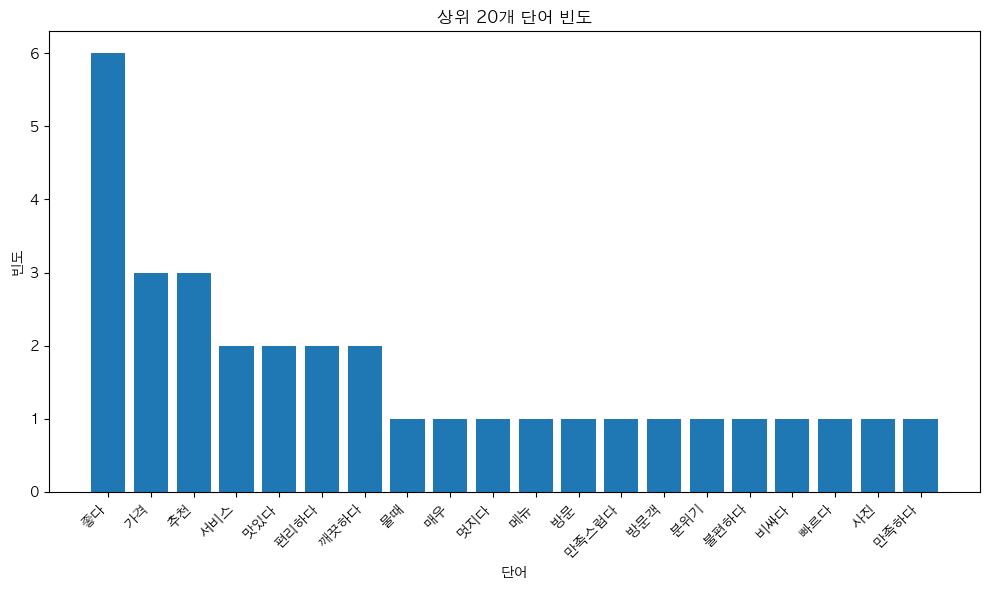

In [9]:

import numpy as np
import matplotlib.pyplot as plt

# 1) 각 단어 총 등장 횟수 계산
word_counts = np.array(dtm.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# 2) 상위 20개 단어 인덱스
top_idx = word_counts.argsort()[::-1][:20]
top_words = words[top_idx]
top_counts = word_counts[top_idx]

# 3) 막대그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(top_words, top_counts)
plt.xticks(rotation=45, ha='right')
plt.title('상위 20개 단어 빈도')
plt.xlabel('단어')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()




### 풀이 설명
1. `dtm.sum(axis=0)`로 각 열(단어)의 빈도 합계를 계산합니다.  
2. `argsort()[::-1][:20]`을 통해 빈도 기준 내림차순 상위 20개 단어를 선별합니다.  
3. Matplotlib으로 시각화해, 자주 등장한 키워드를 한눈에 파악합니다.


## 6. TDM을 활용한 유사 문서 탐색 문제



In [14]:

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# 1) 코사인 유사도 행렬 계산
cos_sim = cosine_similarity(dtm)
# print('cos_sim=', cos_sim)

results = []
# 2) 각 문서별로 상위 2개 유사 문서 찾기
for idx, sims in enumerate(cos_sim):
    # 자기 자신(idx) 제외
    sim_scores = [(j, score) for j, score in enumerate(sims) if j != idx]

    # 유사도 내림차순 정렬 후 상위 2개 선택
    top2 = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:2]
    
    # (리뷰ID, 유사도) 형식으로 변환 (ID는 1부터)
    top2_formatted = [(j+1, round(score, 3)) for j, score in top2]
    results.append({'리뷰ID': idx+1, '유사문서': top2_formatted})

# 3) 판다스 DataFrame으로 정리
df_sim = pd.DataFrame(results)
print(df_sim)


    리뷰ID                        유사문서
0      1        [(2, 0.0), (3, 0.0)]
1      2     [(9, 0.25), (11, 0.25)]
2      3  [(10, 0.224), (16, 0.224)]
3      4     [(6, 0.25), (15, 0.25)]
4      5        [(1, 0.0), (2, 0.0)]
5      6    [(19, 0.408), (4, 0.25)]
6      7        [(1, 0.0), (2, 0.0)]
7      8    [(4, 0.224), (6, 0.224)]
8      9    [(2, 0.25), (19, 0.204)]
9     10  [(13, 0.258), (20, 0.258)]
10    11       [(2, 0.25), (1, 0.0)]
11    12        [(1, 0.0), (2, 0.0)]
12    13  [(20, 0.333), (10, 0.258)]
13    14        [(1, 0.0), (2, 0.0)]
14    15      [(4, 0.25), (6, 0.25)]
15    16      [(3, 0.224), (1, 0.0)]
16    17      [(4, 0.25), (6, 0.25)]
17    18        [(1, 0.0), (2, 0.0)]
18    19    [(6, 0.408), (2, 0.204)]
19    20  [(13, 0.333), (10, 0.258)]




### 풀이 설명
1. `cosine_similarity(dtm)`으로 **모든 문서 쌍**의 유사도 행렬을 얻습니다.  
2. 각 리뷰 행(`sims`)에서 **자기 자신**을 제외한 뒤, **유사도 순**으로 정렬해 상위 2개를 뽑습니다.  
3. 리뷰 ID(1~20)와 유사도 점수를 소수점 셋째 자리까지 반올림해 `(ID, 유사도)` 튜플로 저장합니다.  
4. 최종적으로 `DataFrame` 형태로 결과를 출력해, 어느 리뷰가 서로 유사한지 한눈에 확인할 수 있습니다.  
5. 예를 들어, “서비스가 좋아서…” 리뷰와 “가격 대비 성능이…” 리뷰가 비슷한 이유는 **‘서비스’, ‘성능’, ‘만족’** 같은 키워드를 공통으로 많이 포함하기 때문입니다.
